# Sentiment Analysis with RNN

## Introduction
In this notebook, we build a **Recurrent Neural Network (RNN)** to classify tweet sentiments as positive or negative.  

RNNs are suitable for sequential data like text because they maintain a **memory of previous words** in the sequence, helping the model understand context.  

This notebook will guide you step by step: loading data, preprocessing text, building the RNN model, training, evaluating, and making predictions.

## Why RNN?
- RNNs are designed for **sequence data** like sentences or tweets.
- They maintain **hidden states** to capture previous word context.
- Ideal for small to medium text classification tasks before moving to Transformers.

## Dataset
We use the **Sentiment140 dataset**:

- **Path in project:** `dataset/training.1600000.processed.noemoticon.csv`
- **Kaggle link:** [Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140)
- **Columns:**
  - `0`: sentiment (0 = negative, 4 = positive)
  - `5`: tweet text

We will **sample a smaller portion** of the dataset for faster training.

## Steps
1. Load the dataset  
2. Preprocess the tweets  
3. Encode labels  
4. Tokenize and pad sequences  
5. Build the RNN model  
6. Train and evaluate the model  
7. Test predictions on sample tweets  


In [1]:
# Import libraries
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split

In [2]:
# Step 1: Load the dataset
import pandas as pd

# Load CSV (no header, latin-1 encoding)
df = pd.read_csv(
    "dataset/training.1600000.processed.noemoticon.csv",
    encoding="latin-1", header=None
)

# Quick inspection
print("Shape:", df.shape)

# Keep only first 6 columns (we need sentiment + text mainly)
df = df.iloc[:, :6]
df.columns = ['sentiment', 'id', 'date', 'flag', 'user', 'text']

# Display first few rows
display(df.head(8))


Shape: (1600000, 6)


,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...


# Step 2 — Raw Visualization & Simple EDA

What this cell does (plain words):
- Shows how many positive vs negative tweets there are.
- Displays a few raw example tweets from each class (no cleaning yet).
- Computes basic tweet-length stats (words per tweet) and shows a histogram.
- Finds top words (simple token counts) on a smaller sample for speed.
- Reports a recommended `maxlen` (95th percentile of words) for later tokenization.

Notes:
- We will use a **sample** (default 50k) for the heavier visualizations so the notebook runs fast.
- If `df` is not present in memory (you didn't run the load cell), the code will load only the necessary columns from the CSV.


In [3]:
# Quick inspection
print("Shape:", df.shape)
display(df.head(8))

Shape: (1600000, 6)


,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...


# Class Distribution

Let’s see how many **positive vs negative** tweets exist in the dataset.  
We will also plot a simple **bar chart** to visualize the balance between classes.


Sentiment counts (raw):
sentiment
0    800000
4    800000
Name: count, dtype: int64


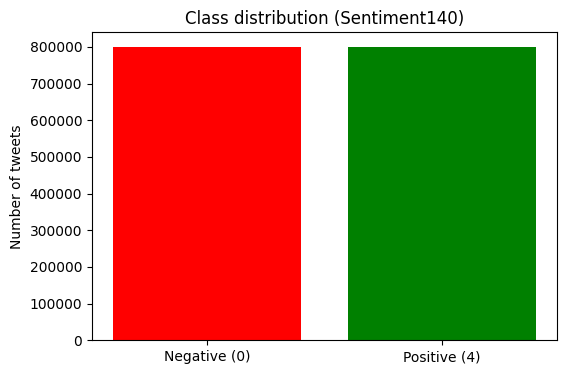

In [4]:
# Class counts
counts = df['sentiment'].value_counts().sort_index()
print("Sentiment counts (raw):")
print(counts)

# bar chart for class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
labels = ['Negative (0)', 'Positive (4)'] if set([0,4]).issubset(counts.index) else counts.index.astype(str)
values = [counts.get(0,0), counts.get(4,0)] if set([0,4]).issubset(counts.index) else counts.values
plt.bar(labels, values, color=["red","green"])
plt.title("Class distribution (Sentiment140)")
plt.ylabel("Number of tweets")
plt.show()


# Inspect Raw Tweets

Here we look at a few **raw tweets** from both classes.  
This helps us understand what the text looks like before any cleaning.


In [5]:
# Show raw tweets
from IPython.display import display

print("\nSample raw negative tweets (3):")
display(df[df['sentiment']==0]['text'].sample(3, random_state=42).tolist())

print("\nSample raw positive tweets (3):")
display(df[df['sentiment']==4]['text'].sample(3, random_state=42).tolist())



Sample raw negative tweets (3):


["@xnausikaax oh no! where did u order from? that's horrible ",
 'A great hard training weekend is over.  a couple days of rest and lets do it again!  Lots of computer time to put in now ',
 "Right, off to work  Only 5 hours to go until I'm free xD"]


Sample raw positive tweets (3):


['Is lookin 4ward to a long weekend  really dont want to go to work 2day tho =[ x',
 '#myweakness  Is music and i live to meet the people who make it ',
 'figured out the Internet on my new iPod ']

# Tweet Length Analysis

We check how long tweets are in terms of **word count**.  
This helps us decide a reasonable `maxlen` for later padding.



Word count stats (sample):
count    50000.000000
mean        12.394280
std          6.811619
min          0.000000
25%          7.000000
50%         11.000000
75%         18.000000
max         35.000000
Name: word_count, dtype: float64


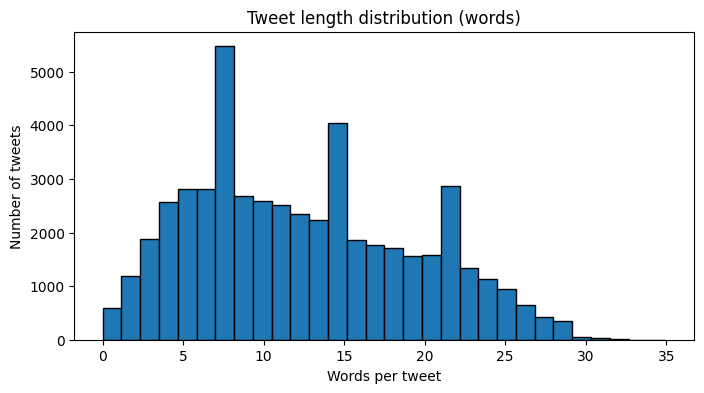

Recommended maxlen (95th percentile): 24


In [6]:
# Tweet length distribution
import re

# small sample for faster EDA
SAMPLE_SIZE = 50000
eda_df = df.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)

# light cleaning (for word counts only)
def clean_for_stats(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)   # remove urls
    text = re.sub(r'@\w+', '', text)               # remove mentions
    text = re.sub(r'[^a-z\s]', '', text)           # keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

eda_df['clean_text'] = eda_df['text'].astype(str).apply(clean_for_stats)
eda_df['word_count'] = eda_df['clean_text'].apply(lambda s: len(s.split()) if s else 0)

# word count statistics
print("\nWord count stats (sample):")
print(eda_df['word_count'].describe())

# histogram
plt.figure(figsize=(8,4))
plt.hist(eda_df['word_count'], bins=30, edgecolor='k')
plt.xlabel('Words per tweet')
plt.ylabel('Number of tweets')
plt.title('Tweet length distribution (words)')
plt.show()

# recommended maxlen (95th percentile)
maxlen_95 = int(eda_df['word_count'].quantile(0.95))
print("Recommended maxlen (95th percentile):", maxlen_95)


# Most Frequent Words

Finally, let’s check the **most common words** in tweets.  
This gives a quick sense of the vocabulary being used.


Top 20 words (sample):
i: 23754
to: 17512
the: 16130
a: 11850
my: 9724
and: 9278
you: 8614
it: 7267
is: 7222
for: 6708
in: 6687
im: 5589
of: 5532
on: 5128
me: 4909
so: 4749
have: 4571
that: 4444
but: 3939
just: 3910


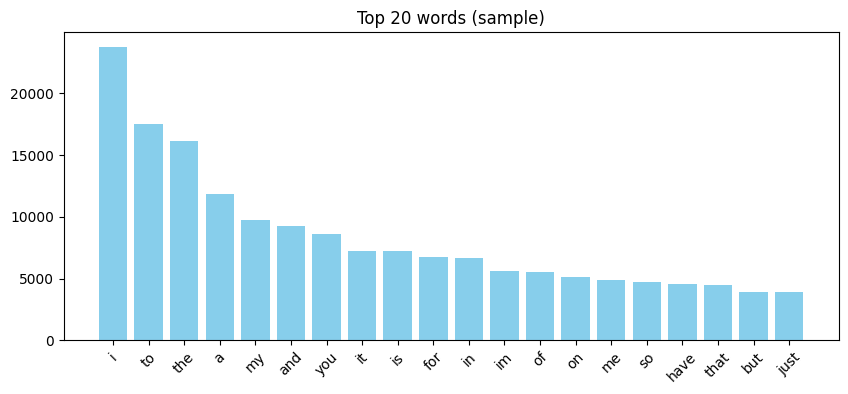


Random cleaned negative examples (3):


['soree throat', 'ow', 'i hate regionalised telly no fa cup on stv football']


Random cleaned positive examples (3):


['is at the airport again played rockfest in kansas city yesterday people insane photos coming soon',
 'cuzz i def diggin the cut bwoy u freakin like ur dad gt gt its a bit scary',
 'yes well keep in mind that steven grant is kind of a dick when writing reviews']

In [7]:
# Top words
from collections import Counter

all_words = ' '.join(eda_df['clean_text'].astype(str)).split()
word_counts = Counter(all_words)
top20 = word_counts.most_common(20)

print("\nTop 20 words (sample):")
for w, c in top20:
    print(f"{w}: {c}")

# bar plot of top words
words, counts_ = zip(*top20)
plt.figure(figsize=(10,4))
plt.bar(words, counts_, color="skyblue")
plt.xticks(rotation=45)
plt.title('Top 20 words (sample)')
plt.show()

# also show a few cleaned examples
print("\nRandom cleaned negative examples (3):")
display(eda_df[eda_df['sentiment']==0]['clean_text'].sample(3, random_state=42).tolist())

print("\nRandom cleaned positive examples (3):")
display(eda_df[eda_df['sentiment']==4]['clean_text'].sample(3, random_state=42).tolist())


# Preprocessing & Data Preparation

Now that we explored the dataset, we prepare it for training.  
Steps include:
- Converting labels to binary (0 = negative, 1 = positive)
- Cleaning tweets (remove URLs, mentions, special characters)
- Tokenizing and padding sequences
- Splitting into train/validation sets


In [8]:
# Convert labels: (0 -> 0, 4 -> 1)
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 4 else 0)

# check distribution after mapping
df['label'].value_counts()


label
0    800000
1    800000
Name: count, dtype: int64

In [9]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)   # remove URLs
    text = re.sub(r'@\w+', '', text)             # remove mentions
    text = re.sub(r'[^a-z\s]', '', text)         # keep only letters
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)

# show a few cleaned examples
df[['text', 'clean_text']].sample(5, random_state=42)


,text,clean_text
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,ahhh i hope your ok
750,"@misstoriblack cool , i have no tweet apps fo...",cool i have no tweet apps for my razr
766711,@TiannaChaos i know just family drama. its la...,i know just family drama its lamehey next time...
285055,School email won't open and I have geography ...,school email wont open and i have geography st...
705995,upper airways problem,upper airways problem


In [10]:
from sklearn.model_selection import train_test_split

X = df['clean_text'].values
y = df['label'].values

# small subset for faster training (optional)
SAMPLE_SIZE = 200000
if SAMPLE_SIZE < len(X):
    X, _, y, _ = train_test_split(X, y, train_size=SAMPLE_SIZE, random_state=42, stratify=y)

# split into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))


Train size: 160000
Validation size: 40000


# Tokenization & Padding

To feed text into an RNN, we must:
- Convert words into integer tokens
- Pad/truncate sequences to a fixed length (`maxlen = 24`)
- Keep a vocabulary of the most frequent words


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# limit vocabulary size (most frequent words only)
VOCAB_SIZE = 20000  
MAXLEN = 24  # from EDA

# fit tokenizer on training data
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAXLEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAXLEN, padding='post', truncating='post')

print("Example sequence:", X_train_seq[0][:10])
print("Padded shape (train):", X_train_pad.shape)
print("Padded shape (val):", X_val_pad.shape)


Example sequence: [38, 2, 396, 33, 389, 7, 30, 106, 321, 18]
Padded shape (train): (160000, 24)
Padded shape (val): (40000, 24)


# Building a Basic RNN Model

Now that our tweets are converted into padded sequences of word IDs, 
we can build a **Recurrent Neural Network (RNN)**.

Model architecture:
1. **Embedding Layer** – turns word IDs into dense vectors (like mini word2vec).
2. **SimpleRNN Layer** – processes sequences, keeping memory of previous words.
3. **Dense Layer** – outputs the sentiment (0 = negative, 1 = positive).


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

VOCAB_SIZE = 20000   # same as tokenizer
EMBEDDING_DIM = 128  # vector size for each word
MAXLEN = 24          # sequence length

# Build RNN model
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_shape=(MAXLEN,)),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])


model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


D:\miniconda_setup\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 24, 128)             │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,572,417 (9.81 MB)

 Trainable params: 2,572,417 (9.81 MB)

 Non-trainable params: 0 (0.00 B)

# Training the RNN Model

We will now train our RNN on the Sentiment140 dataset:
- **Loss**: Binary Crossentropy (since labels are 0/1)
- **Optimizer**: Adam
- **Metrics**: Accuracy
- We'll also monitor validation accuracy to check for overfitting.


In [14]:
# Training parameters
BATCH_SIZE = 512
EPOCHS = 5

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.7496 - loss: 0.5118 - val_accuracy: 0.7789 - val_loss: 0.4721
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.8162 - loss: 0.4099 - val_accuracy: 0.7747 - val_loss: 0.4765
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.8644 - loss: 0.3238 - val_accuracy: 0.7627 - val_loss: 0.5189
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.9052 - loss: 0.2400 - val_accuracy: 0.7420 - val_loss: 0.6286
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9314 - loss: 0.1818 - val_accuracy: 0.7408 - val_loss: 0.6610


# Visualizing Training Progress

We can plot the training vs validation accuracy and loss to see how well the model is learning.


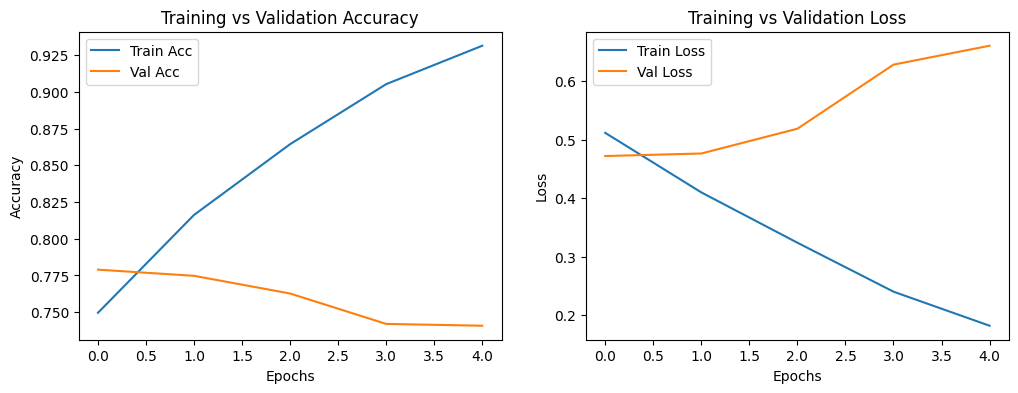

In [15]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


# Model Evaluation

We will:
1. Evaluate the model on the validation set.
2. Generate predictions for new custom tweets.
3. Explore possible improvements (regularization, dropout, etc.).


In [17]:
val_loss, val_acc = model.evaluate(X_val_pad, y_val, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7408 - loss: 0.6610
Validation Accuracy: 0.7408
Validation Loss: 0.6610


In [20]:
# --- Prediction helper ---
def predict_sentiment(text):
    # Convert text → sequence
    seq = tokenizer.texts_to_sequences([text])
    # Pad to same MAX_LEN used in training
    pad = pad_sequences(seq, maxlen=MAXLEN, padding='post', truncating='post')
    # Model prediction
    pred = model.predict(pad, verbose=0)[0][0]
    sentiment = "Positive 😀" if pred > 0.5 else "Negative 😡"
    return sentiment, pred

# --- Test on examples ---
examples = [
    "I love using deep learning for NLP!",
    "This product is the worst experience ever.",
    "I'm not sure how I feel about this update."
]

for txt in examples:
    sentiment, score = predict_sentiment(txt)
    print(f"Tweet: {txt}\nSentiment: {sentiment} (score={score:.4f})\n")


Tweet: I love using deep learning for NLP!
Sentiment: Positive 😀 (score=0.5548)

Tweet: This product is the worst experience ever.
Sentiment: Negative 😡 (score=0.0334)

Tweet: I'm not sure how I feel about this update.
Sentiment: Negative 😡 (score=0.2383)

